In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


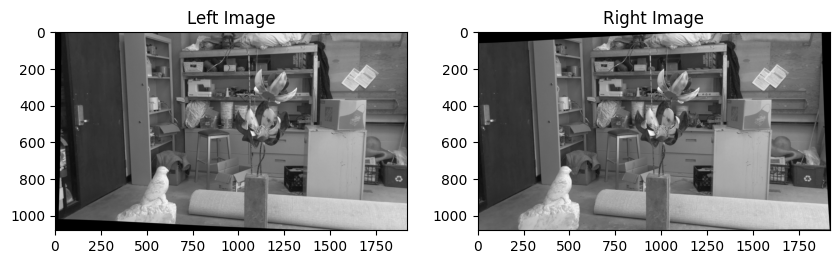

In [9]:
img_left = cv2.imread(r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_b\im0.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_b\im1.png', cv2.IMREAD_GRAYSCALE)

# Check if images are loaded successfully
if img_left is None or img_right is None:
	raise FileNotFoundError("One or both image files could not be loaded. Please check the file paths.")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_left, cmap='gray'), plt.title('Left Image')
plt.subplot(122), plt.imshow(img_right, cmap='gray'), plt.title('Right Image')
plt.show()

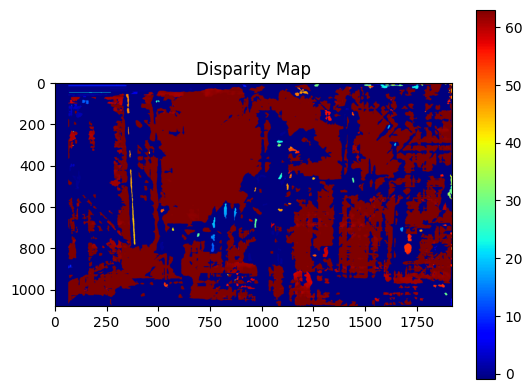

In [10]:
# Parameters for block matching
block_size = 15
min_disp = 0
max_disp = 64
num_disp = max_disp - min_disp  # must be divisible by 16

# Create StereoSGBM matcher
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size**2,
    P2=32 * 3 * block_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

# Compute disparity
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# Display disparity map
plt.imshow(disparity, cmap='jet')
plt.colorbar(), plt.title('Disparity Map')
plt.show()

In [11]:
# Camera parameters (you need to calibrate your camera or use known values)
focal_length = 0.8  # focal length in pixels
baseline = 0.1      # baseline in meters (distance between cameras)

# Convert disparity to depth
depth = (focal_length * baseline) / (disparity + 1e-6)

# Create point cloud
height, width = img_left.shape
y, x = np.mgrid[0:height, 0:width]
points = np.dstack((x, y, depth)).reshape(-1, 3)
colors = cv2.cvtColor(cv2.imread(r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_b\im0.png'), cv2.COLOR_BGR2RGB).reshape(-1, 3)

# Filter out invalid points (where disparity was 0)
valid = depth.reshape(-1) > 0
points = points[valid]
colors = colors[valid]

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors/255.0)

# Visualize
o3d.visualization.draw_geometries([pcd])

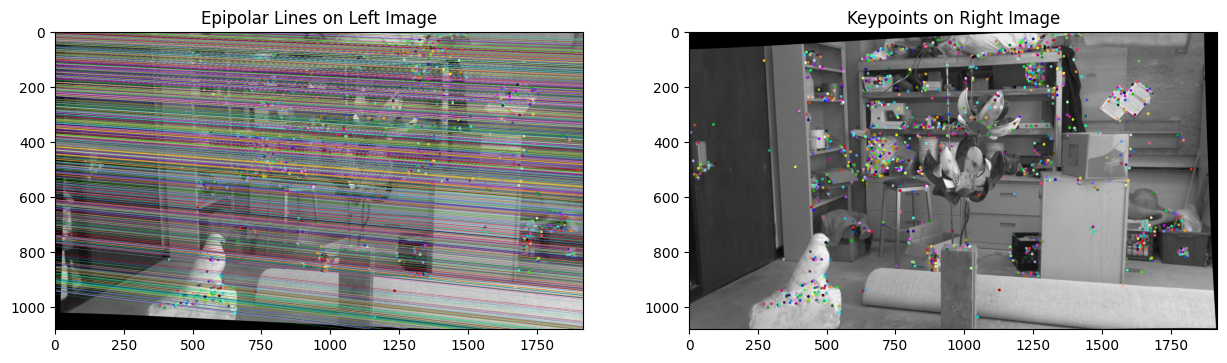

In [13]:
# Find keypoints and matches
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_left, None)
kp2, des2 = sift.detectAndCompute(img_right, None)

# FLANN matcher
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Compute fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Draw epipolar lines
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# Find epilines for points in right image and draw on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img_left, img_right, lines1, pts1, pts2)

# Display epipolar lines
plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(img5), plt.title('Epipolar Lines on Left Image')
plt.subplot(122), plt.imshow(img6), plt.title('Keypoints on Right Image')
plt.show()

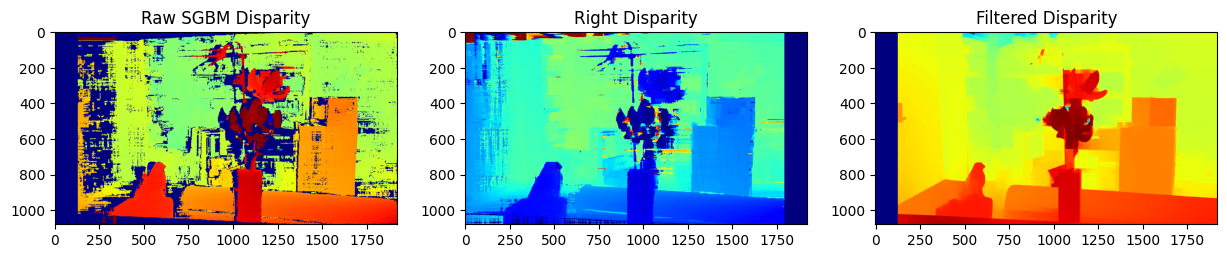

In [14]:

# SGBM Parameters
window_size = 5
min_disp = 0
max_disp = 128  # Should be divisible by 16
num_disp = max_disp - min_disp

# Create SGBM matcher with optimized parameters
left_matcher = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8 * 3 * window_size ** 2,  # Controls disparity smoothness
    P2=32 * 3 * window_size ** 2,  # Should be > P1
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=100,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Compute left disparity map
left_disp = left_matcher.compute(img_left, img_right).astype(np.float32) / 16.0

# Right matcher for consistency check (optional)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
right_disp = right_matcher.compute(img_right, img_left).astype(np.float32) / 16.0

# WLS filter for post-processing
lmbda = 80000
sigma = 1.5
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
filtered_disp = wls_filter.filter(left_disp, img_left, None, right_disp)

# Normalize for visualization
vis_disp = cv2.normalize(filtered_disp, None, alpha=0, beta=255, 
                        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(left_disp, cmap='jet'), plt.title('Raw SGBM Disparity')
plt.subplot(132), plt.imshow(right_disp, cmap='jet'), plt.title('Right Disparity')
plt.subplot(133), plt.imshow(filtered_disp, cmap='jet'), plt.title('Filtered Disparity')
plt.show()

In [15]:
# Camera parameters (replace with your calibration data)
focal_length = 718.856  # in pixels
baseline = 0.537165  # in meters (distance between cameras)
cx = 607.1928  # principal point x
cy = 185.2157  # principal point y

# Create Q matrix for reprojection
Q = np.float32([[1, 0, 0, -cx],
                [0, 1, 0, -cy], 
                [0, 0, 0, focal_length],
                [0, 0, -1/baseline, 0]])

# Convert disparity to 3D points
points = cv2.reprojectImageTo3D(filtered_disp, Q)

# Get colors from left image
colors = cv2.cvtColor(cv2.imread(r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_b\im0.png'), cv2.COLOR_BGR2RGB)

# Mask invalid points (disparity <= 0)
mask = filtered_disp > filtered_disp.min()
out_points = points[mask]
out_colors = colors[mask]

# Function to create Open3D point cloud
def create_point_cloud(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors/255.0)
    return pcd

# Create and visualize point cloud
pcd = create_point_cloud(out_points, out_colors)

# Optional: voxel downsampling
pcd = pcd.voxel_down_sample(voxel_size=0.01)

# Save point cloud
o3d.io.write_point_cloud("output.ply", pcd)

# Visualize
o3d.visualization.draw_geometries([pcd])

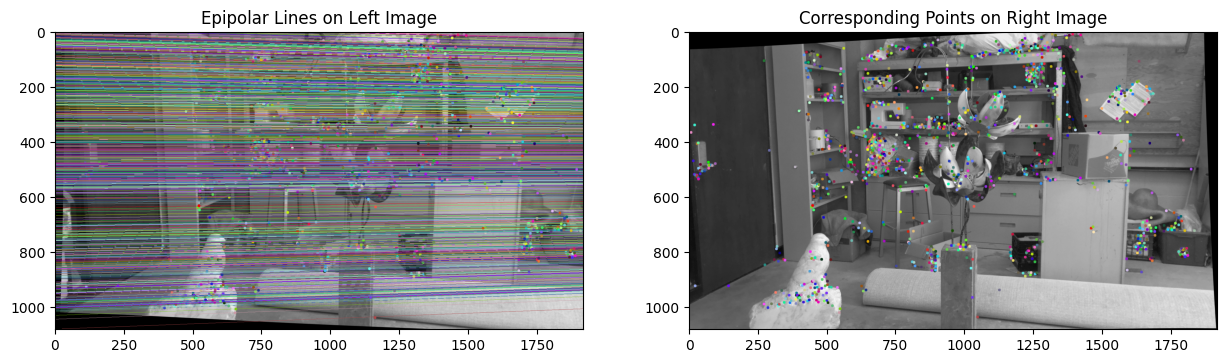

In [16]:
# Find keypoints and matches
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_left, None)
kp2, des2 = sift.detectAndCompute(img_right, None)

# FLANN matcher
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Compute fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Draw epipolar lines
def draw_epilines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -line[2]/line[1]])
        x1, y1 = map(int, [c, -(line[2]+line[0]*c)/line[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# Compute and draw epilines
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img_epi1, img_epi2 = draw_epilines(img_left, img_right, lines1, pts1, pts2)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(img_epi1), plt.title('Epipolar Lines on Left Image')
plt.subplot(122), plt.imshow(img_epi2), plt.title('Corresponding Points on Right Image')
plt.show()